In [ ]:

# 1. INSTALASI LIBRARY YANG DIPERLUKAN
# ===================================================================
!pip install transformers datasets torch accelerate sentencepiece -q
!pip install --upgrade huggingface_hub fsspec datasets transformers
!pip install matplotlib seaborn scikit-learn -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.0/201.0 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 146.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 20.0 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.57.2
    Uninstalling transformers-4.57.2:
      Successfully uninstalled transformers-4.57.2
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling da

In [ ]:
import torch
import pandas as pd
import numpy as np
from transformers import (
    ElectraTokenizer,
    ElectraForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from datasets import Dataset, load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
MODEL_NAME = "ChristopherA08/IndoELECTRA"  # Model ELECTRA Bahasa Indonesia
MAX_LENGTH = 128
BATCH_SIZE = 16
EPOCHS = 4
LEARNING_RATE = 2e-5

# Cek GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device yang digunakan: {device}")

Device yang digunakan: cuda


In [ ]:
# 4. MOUNT GOOGLE DRIVE DAN LOAD DATASET
# ===================================================================
from google.colab import drive
drive.mount('/content/drive')

print("Google Drive berhasil di-mount!")
print("\n" + "="*50)

# GANTI PATH INI SESUAI LOKASI FILE ANDA DI GOOGLE DRIVE
# Contoh format path:
# - '/content/drive/MyDrive/dataset_bukalapak.csv'
# - '/content/drive/MyDrive/Folder Dataset/bukalapak.json'
# - '/content/drive/MyDrive/bukalapak_data.xlsx'

FILE_PATH = '/content/train.csv'  # ⬅️ GANTI INI

print(f"Membaca dataset dari: {FILE_PATH}")

# Deteksi format file dan load sesuai ekstensi
import os
file_extension = os.path.splitext(FILE_PATH)[1].lower()

if file_extension == '.csv':
    df = pd.read_csv(FILE_PATH)
    print("✓ File CSV berhasil dimuat")
elif file_extension == '.json':
    df = pd.read_json(FILE_PATH)
    print("✓ File JSON berhasil dimuat")
elif file_extension in ['.xlsx', '.xls']:
    df = pd.read_excel(FILE_PATH)
    print("✓ File Excel berhasil dimuat")
else:
    raise ValueError(f"Format file tidak didukung: {file_extension}")

# Tampilkan informasi dataset
print(f"\nJumlah data: {len(df)}")
print(f"Kolom yang tersedia: {df.columns.tolist()}")
print(f"\nContoh 3 data pertama:")
print(df.head(3))

# PASTIKAN DATASET MEMILIKI KOLOM 'text' DAN 'label'
# Jika nama kolom berbeda, rename di sini:
# df = df.rename(columns={'deskripsi': 'text', 'kategori': 'label'})

# Bersihkan data: hapus NaN/null
print(f"\nJumlah data sebelum cleaning: {len(df)}")
df = df.dropna(subset=['review_sangat_singkat', 'label'])
print(f"Jumlah data setelah cleaning: {len(df)}")

# Konversi label ke numerik jika masih berupa string
label_encoder = None
if df['label'].dtype == 'object':
    from sklearn.preprocessing import LabelEncoder
    label_encoder = LabelEncoder()
    df['label'] = label_encoder.fit_transform(df['label'])
    print(f"\n✓ Label dikonversi ke numerik")
    print(f"Mapping label: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")

    # Simpan label encoder untuk nanti
    import pickle
    with open('label_encoder.pkl', 'wb') as f:
        pickle.dump(label_encoder, f)
else:
    # Pastikan label mulai dari 0 dan berurutan
    unique_labels = sorted(df['label'].unique())
    print(f"\n✓ Label unik yang ditemukan: {unique_labels}")

    # Remap label ke 0, 1, 2, 3, ... jika belum berurutan
    if unique_labels != list(range(len(unique_labels))):
        print("⚠️ Label tidak berurutan dari 0, melakukan remapping...")
        label_map = {old_label: new_label for new_label, old_label in enumerate(unique_labels)}
        df['label'] = df['label'].map(label_map)
        print(f"✓ Label mapping: {label_map}")

# Pastikan label adalah integer
df['label'] = df['label'].astype(int)

# Validasi label range
min_label = df['label'].min()
max_label = df['label'].max()
num_unique_labels = df['label'].nunique()

print(f"\nValidasi label:")
print(f"- Min label: {min_label}")
print(f"- Max label: {max_label}")
print(f"- Jumlah label unik: {num_unique_labels}")
print(f"- Distribusi label:\n{df['label'].value_counts().sort_index()}")

# CRITICAL: Pastikan label mulai dari 0
if min_label != 0:
    raise ValueError(f"Label harus mulai dari 0, tetapi min_label = {min_label}")

# Konversi ke Hugging Face Dataset
dataset = Dataset.from_pandas(df[['review_sangat_singkat', 'label']])  # Ambil hanya kolom yang diperlukan
print(f"\n✓ Dataset berhasil dikonversi ke format Hugging Face")
print(f"Jumlah data: {len(dataset)}")
print(f"Contoh data: {dataset[0]}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive berhasil di-mount!

Membaca dataset dari: /content/train.csv
✓ File CSV berhasil dimuat

Jumlah data: 96329
Kolom yang tersedia: ['id', 'header_review', 'review_sangat_singkat', 'label']

Contoh 3 data pertama:
   id                 header_review  \
0   0  Mantap Barang Sesuai Pesanan   
1   1                  Mantaps.....   
2   2                 Barang Sesuai   

                               review_sangat_singkat  label  
0                       mantap barang sesuai pesanan      1  
1                                       Mantaps.....      1  
2  Terima kasih buka lapaklapak barang sesuai den...      1  

Jumlah data sebelum cleaning: 96329
Jumlah data setelah cleaning: 96329

✓ Label unik yang ditemukan: [np.int64(0), np.int64(1)]

Validasi label:
- Min label: 0
- Max label: 1
- Jumlah label unik: 2
- Distribusi label:
label
0    12211
1    

In [ ]:
# 5. SPLIT DATA: TRAIN, VALIDATION, TEST
# ===================================================================

train_test = dataset.train_test_split(test_size=0.3, seed=42)

train_dataset = train_test['train']
test_dataset  = train_test['test']

print(f"Train: {len(train_dataset)}, Test: {len(test_dataset)}")

Train: 67430, Test: 28899


In [ ]:
# 6. LOAD TOKENIZER DAN MODEL
# ===================================================================
from transformers import AutoTokenizer, AutoModelForSequenceClassification

print(f"Loading model: {MODEL_NAME}")

# Load tokenizer dengan error handling
try:
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
except:
    print("⚠️ Fast tokenizer gagal, mencoba slow tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=False)

# Tambahkan special tokens jika belum ada
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    print("✓ Pad token diset ke EOS token")

print(f"✓ Tokenizer loaded")
print(f"  - Vocab size: {tokenizer.vocab_size}")
print(f"  - Model max length: {tokenizer.model_max_length}")
print(f"  - Pad token: {tokenizer.pad_token}")
print(f"  - Pad token ID: {tokenizer.pad_token_id}")

# Hitung jumlah label unik DARI DATASET
num_labels = int(df['label'].nunique())
print(f"\n{'='*50}")
print(f"KONFIGURASI MODEL")
print(f"{'='*50}")
print(f"Model: {MODEL_NAME}")
print(f"Jumlah kategori/label: {num_labels}")
print(f"Label range: 0 sampai {num_labels - 1}")
print(f"{'='*50}\n")

# Load model dengan jumlah label yang benar
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    ignore_mismatched_sizes=True  # Penting untuk fine-tuning
)

# Resize token embeddings jika diperlukan
model.resize_token_embeddings(len(tokenizer))

print("✓ Model dan tokenizer berhasil dimuat")

Loading model: ChristopherA08/IndoELECTRA
✓ Tokenizer loaded
  - Vocab size: 35000
  - Model max length: 1000000000000000019884624838656
  - Pad token: [PAD]
  - Pad token ID: 0

KONFIGURASI MODEL
Model: ChristopherA08/IndoELECTRA
Jumlah kategori/label: 2
Label range: 0 sampai 1



Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at ChristopherA08/IndoELECTRA and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model dan tokenizer berhasil dimuat


In [ ]:
# 7. PREPROCESSING DAN TOKENISASI
# ===================================================================
def preprocess_function(examples):
    """
    Fungsi untuk tokenisasi teks
    """
    # Tokenisasi
    tokenized = tokenizer(
        examples['review_sangat_singkat'],
        truncation=True,
        padding='max_length',
        max_length=MAX_LENGTH
    )

    # Pastikan label dalam format yang benar
    tokenized['labels'] = examples['label']

    return tokenized

print("Melakukan tokenisasi dataset...")
# Tokenisasi semua dataset
tokenized_train = train_dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=train_dataset.column_names  # Hapus kolom asli
)
tokenized_test = test_dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=test_dataset.column_names
)

print("✓ Tokenisasi selesai")
print(f"Format tokenized_train: {tokenized_train}")

# Data collator untuk dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Melakukan tokenisasi dataset...


Map:   0%|          | 0/67430 [00:00<?, ? examples/s]

Map:   0%|          | 0/28899 [00:00<?, ? examples/s]

✓ Tokenisasi selesai
Format tokenized_train: Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 67430
})


In [ ]:
# 8. METRICS UNTUK EVALUASI
# ===================================================================
def compute_metrics(eval_pred):
    """
    Fungsi untuk menghitung metrik evaluasi
    """
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels,
        predictions,
        average='weighted'
    )

    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
# 9. TRAINING ARGUMENTS
# ===================================================================
training_args = TrainingArguments(
    output_dir='./results',                    # Folder output
    num_train_epochs=EPOCHS,                   # Jumlah epoch
    per_device_train_batch_size=BATCH_SIZE,    # Batch size training
    per_device_eval_batch_size=BATCH_SIZE,     # Batch size evaluasi
    learning_rate=LEARNING_RATE,               # Learning rate
    warmup_steps=500,                          # Warmup steps
    weight_decay=0.01,                         # Weight decay
    logging_dir='./logs',                      # Folder logs
    logging_steps=50,                          # Log setiap 50 steps
    eval_strategy="no",               # Evaluasi setiap epoch
    save_strategy="epoch",                     # Save model setiap epoch
    load_best_model_at_end=False,              # Load model terbaik
    metric_for_best_model="f1",               # Metrik untuk best model
    push_to_hub=False,                        # Jangan push ke Hugging Face Hub
    report_to="none",
    fp16=True,                                # Mixed precision training (WAJIB!)
    dataloader_num_workers=2,                 # Parallel data loading
    gradient_accumulation_steps=1,            # Gradient accumulation
    save_total_limit=2,                       # Hanya simpan 2 checkpoint terakhir
    disable_tqdm=False,                       # Show progress bar
    # Optimasi tambahan untuk T4 GPU:
    gradient_checkpointing=False,             # False untuk kecepatan
    optim="adamw_torch",  # Disable wandb/tensorboard
)

In [ ]:
# 10. INISIALISASI TRAINER
# ===================================================================
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [ ]:
# 11. MULAI TRAINING
# ===================================================================
print("\n" + "="*50)
print("MEMULAI TRAINING...")
print("="*50 + "\n")

trainer.train()


MEMULAI TRAINING...



Step,Training Loss
50,0.760300
100,0.514000
150,0.341700
200,0.279000
250,0.238100
300,0.234500
350,0.232000
400,0.160800
450,0.177200
500,0.263600


TrainOutput(global_step=16860, training_loss=0.15086123372736351, metrics={'train_runtime': 2532.1448, 'train_samples_per_second': 106.518, 'train_steps_per_second': 6.658, 'total_flos': 1.77415784629248e+16, 'train_loss': 0.15086123372736351, 'epoch': 4.0})


EVALUASI PADA TEST SET



Test Results: {'eval_loss': 0.3148754835128784, 'eval_accuracy': 0.9271255060728745, 'eval_f1': 0.925436609319711, 'eval_precision': 0.9243454921744403, 'eval_recall': 0.9271255060728745, 'eval_runtime': 64.7466, 'eval_samples_per_second': 446.34, 'eval_steps_per_second': 27.909, 'epoch': 4.0}

CONFUSION MATRIX



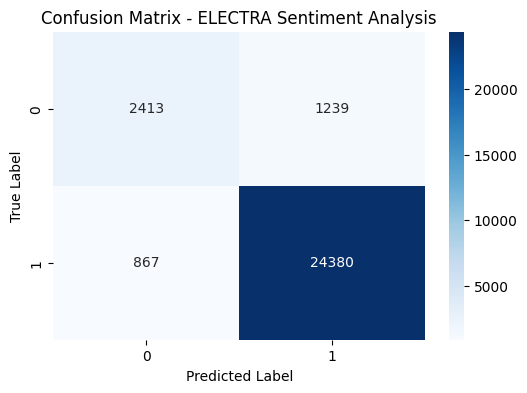


Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.66      0.70      3652
           1       0.95      0.97      0.96     25247

    accuracy                           0.93     28899
   macro avg       0.84      0.81      0.83     28899
weighted avg       0.92      0.93      0.93     28899



In [ ]:
# 12. EVALUASI PADA TEST SET
# ===================================================================
print("\n" + "="*50)
print("EVALUASI PADA TEST SET")
print("="*50 + "\n")

test_results = trainer.evaluate(tokenized_test)
print(f"Test Results: {test_results}")

print("\n" + "="*50)
print("CONFUSION MATRIX")
print("="*50 + "\n")

# Mendapatkan prediksi logits
predictions_output = trainer.predict(tokenized_test)
logits = predictions_output.predictions
y_pred = np.argmax(logits, axis=1)

# Label asli
y_true = predictions_output.label_ids

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - ELECTRA Sentiment Analysis")
plt.show()

# Classification report (lebih lengkap: precision, recall, f1 per kelas)
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

In [ ]:
# 13. SIMPAN MODEL DAN TOKENIZER
# ===================================================================
model.save_pretrained('./electra_bukalapak_model')
tokenizer.save_pretrained('./electra_bukalapak_model')
print("\nModel dan tokenizer berhasil disimpan di './electra_bukalapak_model'")


Model dan tokenizer berhasil disimpan di './electra_bukalapak_model'


In [ ]:
# 14. FUNGSI UNTUK PREDIKSI
# ===================================================================
def predict_text(text, model, tokenizer):
    """
    Fungsi untuk memprediksi kategori dari teks
    """
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=MAX_LENGTH
    ).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        predicted_class = torch.argmax(predictions, dim=-1).item()
        confidence = predictions[0][predicted_class].item()

    return predicted_class, confidence

In [ ]:
# 15. CONTOH PENGGUNAAN PREDIKSI
# ===================================================================
print("\n" + "="*50)
print("CONTOH PREDIKSI MENGGUNAKAN DATASET BUATAN")
print("="*50 + "\n")

test_texts = [
    "Sepatu olahraga Nike Air Max bagus banget",
    "Laptop Dell Inspiron 14 inch SSD 512GB nya b aja",
    "Kalau ga niat jualan ga usah jualan disini",
    "Penjual tolol",
    " Waktu ditanya dibilang botol pake segel original, tapi yg dikirim tdk pake segel plastik original dan tulisan dan logo garuda dibotol rusak semua krn tanpa segel plastik, sangat kecewa order di lapak ini, pdhl 6btl yg diorder akan dijual lagi, kl begini kondisinya tdk laku dijual lagi, mohon penjelasannya",
    "pintarnya penjual ini jualan ya, masak mesen sepatu malah dikasi sarung tangan. ga lagi beli disini",
    "Penjual ga niatr jualan, bodoh",
    "Barang sangat bagus lho, sangat bagus untuk gw hantam ke lu punya muka"
]

model.to(device)
for text in test_texts:
    pred_label, confidence = predict_text(text, model, tokenizer)
    print(f"Text: {text}")
    print(f"Predicted Label: {pred_label}")
    print(f"Confidence: {confidence:.4f}")
    print("-" * 50)

print("\n" + "="*60)
print("10 CONTOH HASIL PREDIKSI MENGGUNAKAN TEST DATASET")
print("="*60 + "\n")

# Ambil prediksi dan label asli dari test set
pred_output = trainer.predict(tokenized_test)
logits = pred_output.predictions
y_pred = np.argmax(logits, axis=1)
y_true = pred_output.label_ids

# Konversi HuggingFace test_dataset kembali menjadi DataFrame
df_test = pd.DataFrame(test_dataset)

# Loop 10 contoh
for i in range(10):
    teks = df_test.iloc[i]["review_sangat_singkat"]
    label_asli = y_true[i]
    prediksi = y_pred[i]
    status = "BENAR" if label_asli == prediksi else "SALAH"

    print(f"Teks Review  : {teks}")
    print(f"Label Asli   : {label_asli} ({'Negatif' if label_asli==0 else 'Positif'})")
    print(f"Prediksi     : {prediksi} ({'Negatif' if prediksi==0 else 'Positif'})")
    print(f"Hasil        : {status}")
    print("-" * 60)



CONTOH PREDIKSI MENGGUNAKAN DATASET BUATAN

Text: Sepatu olahraga Nike Air Max bagus banget
Predicted Label: 1
Confidence: 0.9996
--------------------------------------------------
Text: Laptop Dell Inspiron 14 inch SSD 512GB nya b aja
Predicted Label: 1
Confidence: 0.9923
--------------------------------------------------
Text: Kalau ga niat jualan ga usah jualan disini
Predicted Label: 0
Confidence: 0.9973
--------------------------------------------------
Text: Penjual tolol
Predicted Label: 0
Confidence: 0.9970
--------------------------------------------------
Text:  Waktu ditanya dibilang botol pake segel original, tapi yg dikirim tdk pake segel plastik original dan tulisan dan logo garuda dibotol rusak semua krn tanpa segel plastik, sangat kecewa order di lapak ini, pdhl 6btl yg diorder akan dijual lagi, kl begini kondisinya tdk laku dijual lagi, mohon penjelasannya
Predicted Label: 0
Confidence: 0.9971
--------------------------------------------------
Text: pintarnya penjual 

Teks Review  : Aaaaaaaa aaaaaaaa aaaaaaaa aaaaaaaa aaaaaaaa aaaaaaaa aaaaaaaa aaaaaaaa aaaaaaaa aaaaaaaa aaaaaaaa aaaaaaaa aaaaaaaa aaaaaaaa aaaaaaaa aaaaaaaa
Label Asli   : 1 (Positif)
Prediksi     : 1 (Positif)
Hasil        : BENAR
------------------------------------------------------------
Teks Review  : Respondnya cepat, pelapaknya baik, barangnya bagus, ngga kebesaran dan ngga kekecilan pokoknya recomended banget. Ngga nyesel deh, jadi pengen belanja di sini lagi dan lagi.
Label Asli   : 1 (Positif)
Prediksi     : 1 (Positif)
Hasil        : BENAR
------------------------------------------------------------
Teks Review  : next order lagi kak.................................
Label Asli   : 1 (Positif)
Prediksi     : 1 (Positif)
Hasil        : BENAR
------------------------------------------------------------
Teks Review  : barangnya bagus berfungsi dgn baik 
Label Asli   : 1 (Positif)
Prediksi     : 1 (Positif)
Hasil        : BENAR
--------------------------------------------------